<a href="https://colab.research.google.com/github/mylesshin/shin-park-wildfire/blob/main/wildfire-plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!pip install matplotlib seaborn scikit-learn 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
file_path = 'wildfiredb.csv'

# Read only the first row of the CSV file to extract the column names
with open(file_path, 'r') as f:
    df = pd.read_csv(f, nrows=10000).dropna()

filtered_df = df[df['Neighbour_frp'] != 0]
# print(filtered_df)

In [73]:
filtered_df = filtered_df.select_dtypes(include=[np.number])  # Select only numeric columns


In [ ]:
#### Correlations and Linear Regression Model

In [ ]:
corr_matrix = df.corr()
corr_with_target = corr_matrix['frp'].sort_values(ascending=False)

# Get the top 5 correlated features
top_features = corr_with_target[1:6].index.tolist()
top_features

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE


In [79]:
# Neighbour FRP as target variable
X = filtered_df.drop('Neighbour_frp', axis=1) # features
y = filtered_df['Neighbour_frp'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()

# Use the RFE method to select the top 5 features
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Print the top 5 features
top_5 = X_train.columns[ref.support_]
print(top_5)


Index(['CBD2016_mode', 'CBH2016_min', 'EVH2012_max',
       'Neighbour_CBD2012_median', 'Neighbour_CBD2012_mean'],
      dtype='object')


In [ ]:
# Train the model using the selected features
model.fit(X_train.loc[:, rfe.support_], y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test.loc[:, rfe.support_])
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

<Axes: xlabel='ELEV2016_mean', ylabel='Neighbour_frp'>

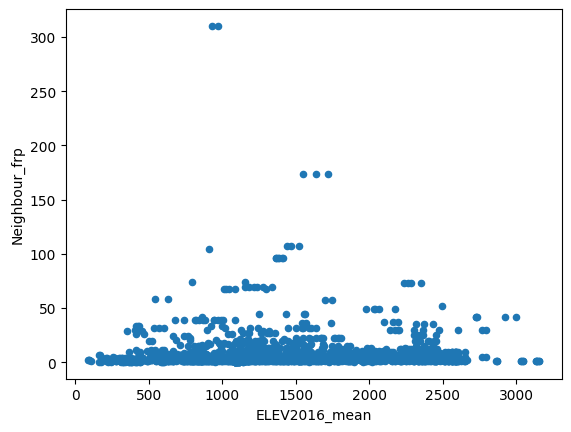

In [ ]:
filtered_df.plot.scatter(x='ELEV2016_mean', y='Neighbour_frp')

R^2 score: -0.28207827866432367


In [ ]:
corr = df['frp'].corr(df['CC2016_mean'])

# Print the correlation matrix
print(corr)

-0.09128453220457865


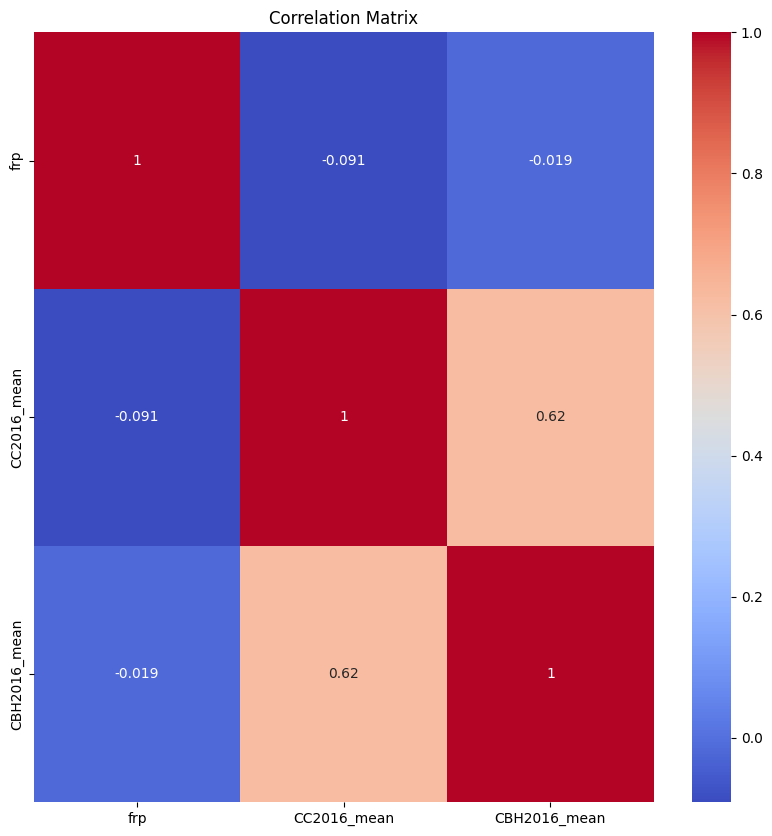

In [ ]:
df = df.select_dtypes(include=[np.number])  # Select only numeric columns

subset = df[['frp', 'CC2016_mean', 'CBH2016_mean']]

# Calculate the correlation matrix between the remaining columns
corr_matrix = subset.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

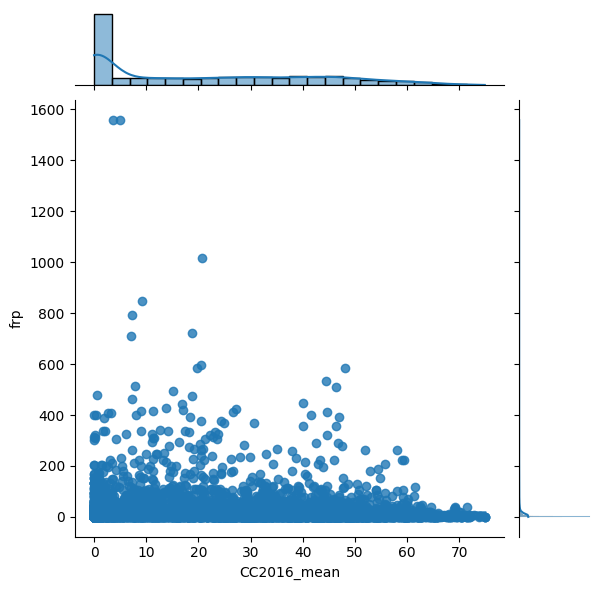

In [ ]:
sns.jointplot(x='CC2016_mean', y='frp', data=df, kind="reg");

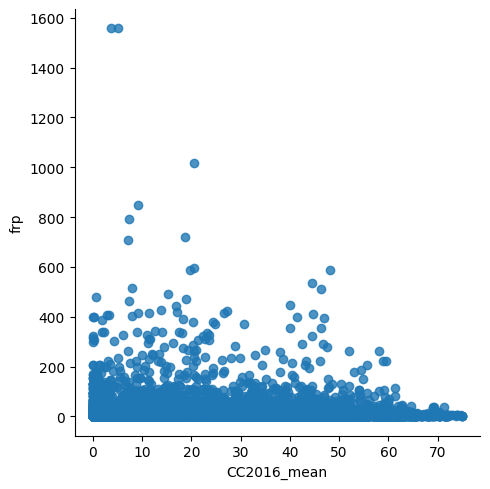

In [ ]:
sns.lmplot(x='CC2016_mean', y='frp', hue='', data=df);

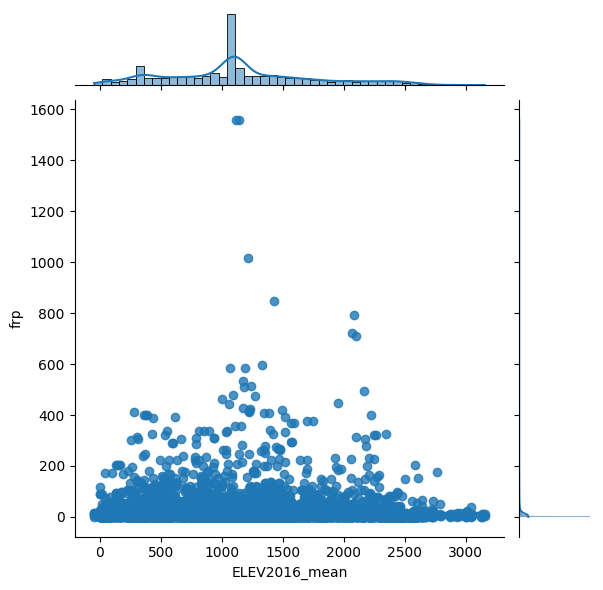

In [ ]:
sns.jointplot(x='ELEV2016_mean', y='frp', data=df, kind="reg");

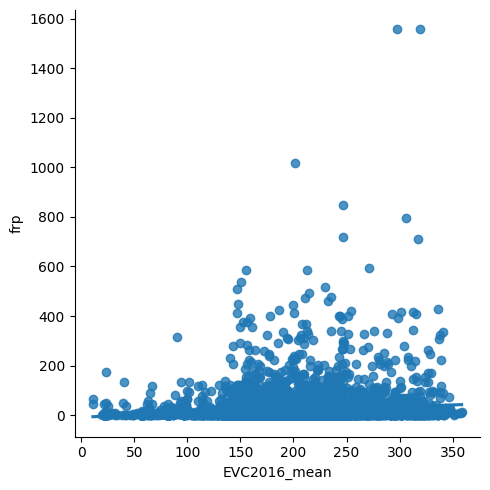

In [ ]:
sns.lmplot(x='EVC2016_mean', y='frp', data=df);

In [ ]:
import pickle

a = [1,2,3]

# rest of work that I want to save

pickle.dump(a, open("/content/drive/MyDrive/BigData/mydata.pk", "wb"))

In [ ]:
a

[1, 2, 3]

In [ ]:
import pickle

a = pickle.load(open("/content/drive/MyDrive/BigData/mydata.pk", "rb"))
a

[1, 2, 3]